In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("ionosphere_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

In [5]:
normalized_data=df.copy()
normalized_data.shape

(351, 35)

In [6]:
normalized_data[normalized_data.duplicated()]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
248,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,b


In [7]:
normalized_data.drop_duplicates(inplace = True)
normalized_data.shape

(350, 35)

In [8]:
normalized_data["feature2"].value_counts()

0    350
Name: feature2, dtype: int64

In [9]:
normalized_data.drop(columns=["feature2"], inplace = True)
normalized_data.shape

(350, 34)

In [10]:
data = normalized_data 
data.shape

(350, 34)

In [11]:
class_g = data[data["label"]=="g"]
class_b = data[data["label"]=="b"]

In [12]:
class_g.shape

(225, 34)

In [13]:
class_b.shape

(125, 34)

In [14]:
class_b_over= class_b.sample(len(class_g), replace = True,)
data_over = pd.concat([class_b_over, class_g], axis=0)

In [15]:
data_over["label"].value_counts()

b    225
g    225
Name: label, dtype: int64

In [16]:
len(data_over)

450

In [17]:
x_data = data_over.drop(columns=["label"])
label = data_over["label"]

In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(x_data, label, test_size=.4, random_state=1, stratify=label)

In [19]:
train_data.shape, test_data.shape

((270, 33), (180, 33))

In [20]:
train_labels.shape, test_labels.shape

((270,), (180,))

In [21]:
mean=train_data.mean(axis=0)
std=train_data.std(axis=0)
train_data = (train_data-mean)/std
test_data=(test_data-mean)/std

In [22]:
train_labels = np.where(train_labels =="g", 1, 0 )
test_labels = np.where(test_labels =="g",1,0)

In [23]:
def build_model():
  model=models.Sequential()
  model.add(layers.Dense(16,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=0.001) , activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dropout(.1))
  model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=0.001), activation = "relu" ))
  model.add(layers.Dropout(.1))
  model.add(layers.Dense(1, activation="sigmoid"))

  model.compile(optimizer="rmsprop", loss = "binary_crossentropy", metrics=["accuracy"])
  return model

In [25]:
k= 5
num_val_sample = len(train_data) // k
num_epochs =50
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=1, verbose=0)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_loss)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
all_scores

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


[0.2323954701423645,
 0.3674275577068329,
 0.2838438153266907,
 0.4324598014354706,
 0.36724692583084106]

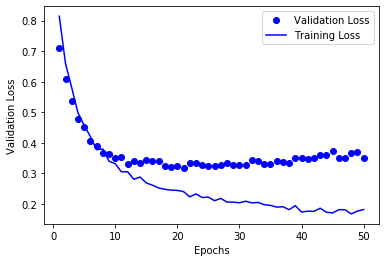

In [26]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_val_loss_hist[:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_loss_hist[:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

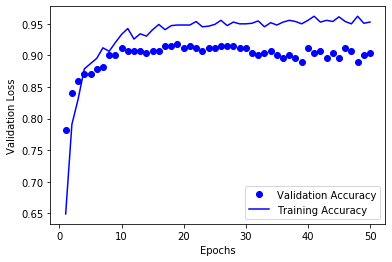

In [27]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_val_acc_hist[:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_acc_hist[:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [28]:
model=models.Sequential()
model.add(layers.Dense(16,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=0.001) , activation="relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dropout(.1))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=0.001), activation = "relu" ))
model.add(layers.Dropout(.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss = "binary_crossentropy", metrics=["accuracy"])

In [29]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
9/9 [==============================] - 1s 5ms/step - loss: 0.9653 - accuracy: 0.4756
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 0.8362 - accuracy: 0.5557
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 0.7649 - accuracy: 0.6954
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.7654 - accuracy: 0.7520
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.7940
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.8137
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.7876
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.8157
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5848 - accuracy: 0.8424
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.8636
Epoch 11/100
9/9 [===========

9/9 [==============================] - 0s 2ms/step - loss: 0.2272 - accuracy: 0.9703
Epoch 85/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2335 - accuracy: 0.9694
Epoch 86/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9901
Epoch 87/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2418 - accuracy: 0.9543
Epoch 88/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9737
Epoch 89/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2310 - accuracy: 0.9649
Epoch 90/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2241 - accuracy: 0.9750
Epoch 91/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2435 - accuracy: 0.9575
Epoch 92/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.9778
Epoch 93/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9816
Epoch 94/100
9/9 [===============

In [30]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

6/6 [==============================] - 0s 4ms/step - loss: 0.2274 - accuracy: 0.9389


In [31]:
test_acc_score *100

93.88889074325562

In [32]:
prediction=model.predict(test_data)
pred_norm =np.where(prediction>.5, 1, 0)
pred_norm=np.where(pred_norm==1, "g", "b")

In [33]:
pred_norm = pred_norm.reshape(pred_norm.shape[0],)
pred_norm[:10].T

array(['g', 'b', 'g', 'b', 'g', 'g', 'b', 'g', 'b', 'b'], dtype='<U1')

In [34]:
prediction[:10].T

array([[8.9051771e-01, 3.3903897e-02, 9.9200583e-01, 9.0754969e-05,
        9.9096322e-01, 9.9907678e-01, 3.1650066e-04, 9.6182454e-01,
        3.0744851e-02, 1.4494687e-05]], dtype=float32)

In [35]:
test_labels_new = np.where(test_labels==1, "g", "b")

In [36]:
test_labels_new[:10]

array(['g', 'b', 'g', 'b', 'g', 'g', 'b', 'g', 'b', 'b'], dtype='<U1')

In [37]:
c= pred_norm.size
c

180

In [38]:
comapre_pred_test = test_labels_new == pred_norm

In [39]:
b = comapre_pred_test[comapre_pred_test[:]==True].size
b

169

In [40]:
a = comapre_pred_test[comapre_pred_test[:]==False].size
a

11

In [41]:
print("Incorrect Predictions are:", a, "and Correct predictions are :", b, " the percentage is:", round((b/c)*100,2), "%"  )

Incorrect Predictions are: 11 and Correct predictions are : 169  the percentage is: 93.89 %
